In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [43]:
data=pd.read_excel("Final data set.xlsx")
data.set_index("Date",inplace=True)
data.head()


,Average temperature [°C],Wind speed [m/s],Maximum gust speed [m/s],Consumption
Date,,,,
2018-01-01 00:00:00,-0.4,5.0,7.7,9410.0
2018-01-01 01:00:00,-0.5,6.0,9.7,9242.0
2018-01-01 02:00:00,-0.4,5.0,8.2,9260.0
2018-01-01 03:00:00,-0.1,5.1,8.5,9364.0
2018-01-01 04:00:00,0.1,5.5,8.7,9586.0


Exploratory Data Analysis (EDA)

In [44]:
missing_values=data.isnull().sum()
data_type=data.dtypes
#missing_values,data_type

In [45]:
summary_statistics = data.describe().round(1)
#summary_statistics


Correlation Analysis

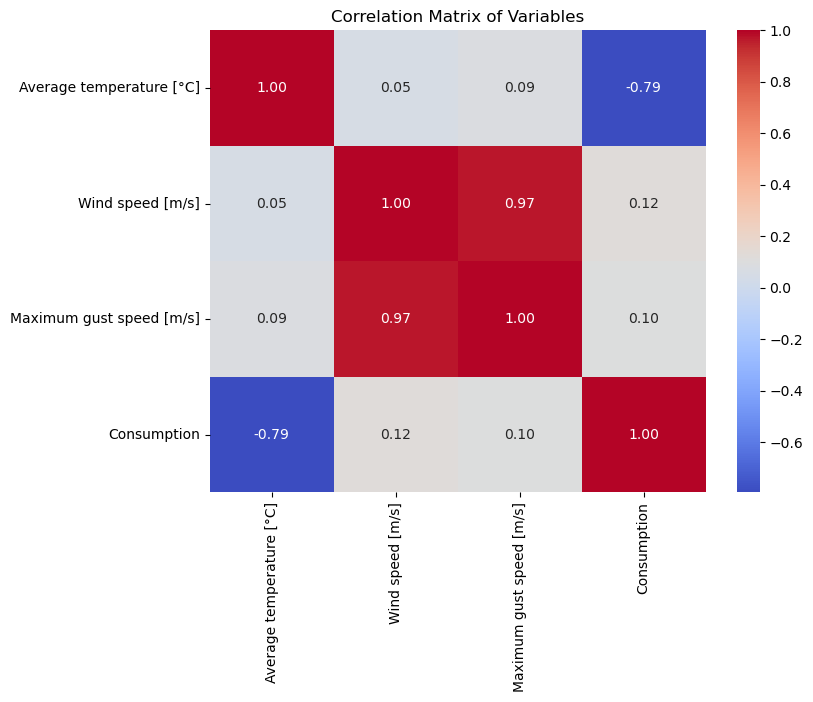

In [46]:
correlation_matrix=data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Variables")
plt.show()

Feature Engineering

1. Times-based features

In [39]:
import holidays

In [51]:
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])


In [52]:
Finland_holidays=holidays.Finland()

In [66]:
data['IsHoliday'] = data['Date'].dt.date.apply(
    lambda x: 1 if (x in Finland_holidays or (x.month == 12 and x.day in [24, 25, 26])) else 0)
data['Hour']=data['Date'].dt.hour
data['DayOfWeek']=data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month  # Month
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)  # Weekend flag
data.head()

,Date,Average temperature [°C],Wind speed [m/s],Maximum gust speed [m/s],Consumption,IsHoliday,Hour,DayofWeek,Month,DayOfWeek,IsWeekend,Lag_1H,Lag_24H,Rolling_3H,Rolling_6H,Rolling_24H
0,2018-01-01 00:00:00,-0.4,5.0,7.7,9410.0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,-0.5,6.0,9.7,9242.0,1,1,0,1,0,0,9410.0,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,-0.4,5.0,8.2,9260.0,1,2,0,1,0,0,9242.0,NaN,9304.000000,NaN,NaN
3,2018-01-01 03:00:00,-0.1,5.1,8.5,9364.0,1,3,0,1,0,0,9260.0,NaN,9288.666667,NaN,NaN
4,2018-01-01 04:00:00,0.1,5.5,8.7,9586.0,1,4,0,1,0,0,9364.0,NaN,9403.333333,NaN,NaN


2. Lagged Features

In [58]:
data['Lag_1H'] = data['Consumption'].shift(1)  
data['Lag_24H'] = data['Consumption'].shift(24)  

# Create rolling average features for Consumption
data['Rolling_3H'] = data['Consumption'].rolling(window=3).mean()  
data['Rolling_6H'] = data['Consumption'].rolling(window=6).mean()  
data['Rolling_24H'] = data['Consumption'].rolling(window=24).mean() 

data.head()  

,Date,Average temperature [°C],Wind speed [m/s],Maximum gust speed [m/s],Consumption,IsHoliday,Hour,DayofWeek,Month,DayOfWeek,IsWeekend,Lag_1H,Lag_24H,Rolling_3H,Rolling_6H,Rolling_24H
0,2018-01-01 00:00:00,-0.4,5.0,7.7,9410.0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,-0.5,6.0,9.7,9242.0,1,1,0,1,0,0,9410.0,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,-0.4,5.0,8.2,9260.0,1,2,0,1,0,0,9242.0,NaN,9304.000000,NaN,NaN
3,2018-01-01 03:00:00,-0.1,5.1,8.5,9364.0,1,3,0,1,0,0,9260.0,NaN,9288.666667,NaN,NaN
4,2018-01-01 04:00:00,0.1,5.5,8.7,9586.0,1,4,0,1,0,0,9364.0,NaN,9403.333333,NaN,NaN


3. feature selection

3.1. Correlation Analysis

In [59]:
correlation_matrix=data.corr()
correlation_with_target = correlation_matrix['Consumption'].sort_values(ascending=False)

correlation_with_target

Consumption                 1.000000
Rolling_3H                  0.991632
Lag_1H                      0.989813
Rolling_6H                  0.965689
Lag_24H                     0.948896
Rolling_24H                 0.928279
Wind speed [m/s]            0.119374
Maximum gust speed [m/s]    0.098988
Hour                        0.062134
IsHoliday                  -0.040273
DayofWeek                  -0.117354
DayOfWeek                  -0.117354
Date                       -0.129018
IsWeekend                  -0.150501
Month                      -0.211990
Average temperature [°C]   -0.794809
Name: Consumption, dtype: float64

Feature reduction

In [101]:
# Drop features with weak correlations based on correlation analysis
# Retain features with absolute value > 0.1
selected_features = correlation_with_target[correlation_with_target.abs() > 0.1].index.tolist()
data_reduced = data[selected_features ] 
data_reduced.dropna(axis=0,inplace=True)
data_reduced.head()



C:\Users\k423994\AppData\Local\Temp\ipykernel_16956\752431898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reduced.dropna(axis=0,inplace=True)


,Consumption,Rolling_3H,Lag_1H,Rolling_6H,Lag_24H,Rolling_24H,Wind speed [m/s],DayofWeek,DayOfWeek,Date,IsWeekend,Month,Average temperature [°C]
24,9367.0,9595.000000,9562.0,9952.666667,9410.0,10019.958333,3.3,1,1,2018-01-02 00:00:00,0,1,2.1
25,9271.0,9400.000000,9367.0,9800.500000,9242.0,10021.166667,6.8,1,1,2018-01-02 01:00:00,0,1,3.6
26,9304.0,9314.000000,9271.0,9608.166667,9260.0,10023.000000,7.5,1,1,2018-01-02 02:00:00,0,1,3.8
27,9584.0,9386.333333,9304.0,9490.666667,9364.0,10032.166667,7.8,1,1,2018-01-02 03:00:00,0,1,3.8
28,10326.0,9738.000000,9584.0,9569.000000,9586.0,10063.000000,7.4,1,1,2018-01-02 04:00:00,0,1,3.8


Model


Linear Regression

In [150]:
X=data_reduced.drop(columns=['Consumption','Date'])
Y=data_reduced['Consumption']

In [151]:
X_train, X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [152]:
Linear_regression_model=LinearRegression()
Linear_regression_model.fit(X_train,Y_train)
Y_pred_LR=Linear_regression_model.predict(X_test)


In [153]:
mae_LR=mean_absolute_error(Y_test,Y_pred_LR)
mse_LR=mean_squared_error(Y_test,Y_pred_LR)
r2_LR=r2_score(Y_test,Y_pred_LR)

In [154]:
print (f"MAE LR is {mae_LR}")
print (f"MSE LR is {mse_LR}")
print (f"R2 LR score is {r2_LR}")

MAE LR is 94.08348779870008
MSE LR is 15204.493627282109
R2 LR score is 0.9940054753938815


Model: Random Forest Regression

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [156]:
Random_forest_model=RandomForestRegressor(random_state=42)
Random_forest_model.fit(X_train,Y_train)
Y_pred_RF=Random_forest_model.predict(X_test)

In [157]:
mae_RF=mean_absolute_error(Y_test,Y_pred_RF)
mse_RF=mean_squared_error(Y_test,Y_pred_RF)
r2_RF=r2_score(Y_test,Y_pred_RF)

In [158]:
print (f"MAE RF is {mae_RF}")
print (f"MSE RF is {mse_RF}")
print (f"R2 RF score is {r2_RF}")

MAE RF is 75.42013713061675
MSE RF is 10722.431557522452
R2 RF score is 0.995772573465146


Model: Gradient Boosting Regression

In [159]:
from sklearn.ensemble import GradientBoostingRegressor

In [160]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, Y_train)
Y_pred_GB = gb_model.predict(X_test)


In [161]:
mae_GB = mean_absolute_error(Y_test, Y_pred_GB)
mse_GB = mean_squared_error(Y_test, Y_pred_GB)
r2_GB = r2_score(Y_test, Y_pred_GB)

print (f"MAE GB is {mae_GB}")
print (f"MSE GB is {mse_GB}")
print (f"R2 GB score is {r2_GB}")

MAE GB is 116.16796587740258
MSE GB is 25764.524206006627
R2 GB score is 0.9898420770790608


Model: XGBoost

In [162]:
from xgboost import XGBRegressor


In [163]:
data_cleaned = data_reduced.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace('°C', ''))
X=data_cleaned.drop(columns=['Consumption','Date'])

Y=data_cleaned['Consumption']
X_train, X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [164]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train,Y_train)

Y_pred_XGB = xgb_model.predict(X_test)

In [165]:
# Evaluate the model
mae_XGB = mean_absolute_error(Y_test, Y_pred_XGB)
mse_XGB = mean_squared_error(Y_test, Y_pred_XGB)
r2_XGB = r2_score(Y_test, Y_pred_XGB)

print (f"MAE XGB is {mae_XGB}")
print (f"MSE XGB is {mse_XGB}")
print (f"R2 XGB score is {r2_XGB}")

MAE XGB is 83.31570226922614
MSE XGB is 12430.053180192042
R2 XGB score is 0.9950993264576519


Comparison of models

In [166]:
Results={"Models":['Linear Regression','Random Forest', 'Grsadient Boosting','XGBoost'],
         "MAE":[mae_LR,mae_RF,mae_GB,mae_XGB],
         "MSE":[mse_LR,mse_RF,mse_GB,mse_XGB],
         "R2":[r2_LR,r2_RF,r2_GB,r2_XGB],
         }

In [167]:
Results=pd.DataFrame(Results)
Results=Results.sort_values(by='MAE',ascending=True)
Results.head()

,Models,MAE,MSE,R2
1,Random Forest,75.420137,10722.431558,0.995773
3,XGBoost,83.315702,12430.053180,0.995099
0,Linear Regression,94.083488,15204.493627,0.994005
2,Grsadient Boosting,116.167966,25764.524206,0.989842


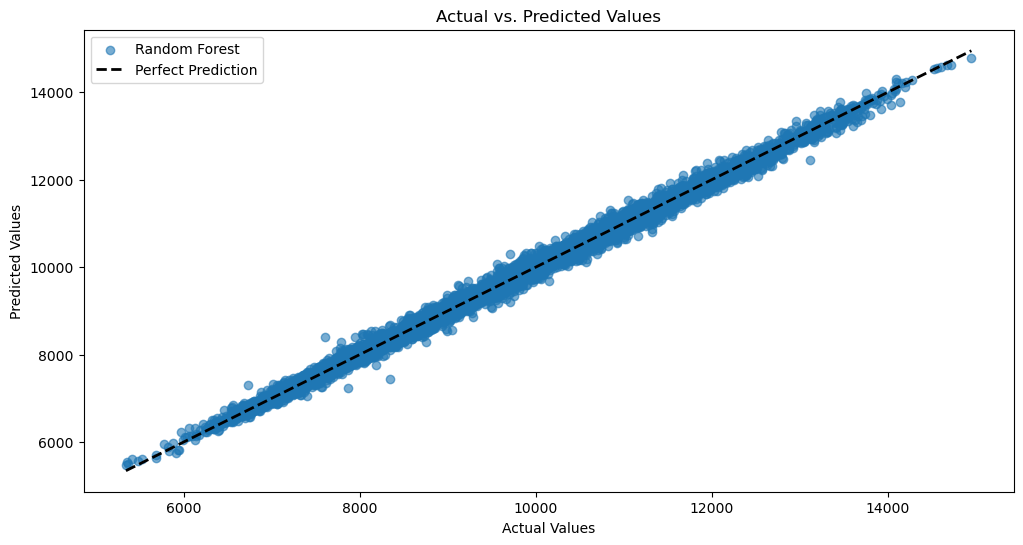

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual vs. predicted for each model
#plt.scatter(Y_test, Y_pred_LR, label="Linear Regression", alpha=0.6)
plt.scatter(Y_test, Y_pred_RF, label="Random Forest", alpha=0.6)
#plt.scatter(Y_test, Y_pred_GB, label="Gradient Boosting", alpha=0.6)
#plt.scatter(Y_test, Y_pred_XGB, label="XGBoost", alpha=0.6)

# Add plot details
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()